<a href="https://colab.research.google.com/github/Wissben/intent_classification_train/blob/master/real_encoder_decoder_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
!sudo pip install tensorflow-gpu

     |████████████████████████████████| 345.2MB 54kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!rm -rf intent_classification
!git clone https://github.com/Wissben/intent_classification.git
# !rm -rf datasets
# !git clone https://github.com/Wissben/datasets.git

Cloning into 'intent_classification'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 193 (delta 87), reused 152 (delta 50), pack-reused 0
Receiving objects: 100% (193/193), 611.57 KiB | 7.94 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [0]:
#!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!cp gdrive/My\ Drive/dataset.tar .
!tar -xvf dataset.tar
# !wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00425/UTQD.2016

train_intents_cleaned.json


# Imports

In [0]:
import numpy as np
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.layers import (LSTM, 
                                     Bidirectional, 
                                     CuDNNGRU,
                                     CuDNNLSTM,
                                     Dense,
                                     Embedding,
                                     Input,
                                     TimeDistributed,
                                     Concatenate,
                                     Multiply,
                                     Activation,
                                     Flatten,
                                     Convolution1D,
                                     Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import load_model as lm
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import numpy as np
import gensim
import pprint
import numpy as np

import os
import json
from pprint import pprint as pr
import re
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer

import itertools
import random

from sklearn.utils import class_weight
import matplotlib.pyplot as plt

import copy
from abc import ABCMeta, abstractmethod
import csv

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Classes definitions

In [0]:
class EncoderDecoder(metaclass=ABCMeta):
  """
  Class implementation for the encoder decoder architecture
  """

  def __init__(self,kwargs):
      for k in kwargs:
        self.__dict__[k]=kwargs[k]
      """
      Must provide a dictionary containing the following keys/values :
      {_
          'model_name': 'base',
          'encoder_input_dim': vector_size+postag_vec_size,
          'encoder_output_dim': 64,
          'encoder_dense_units': 64,
          'encoder_dense_output_dim' :n_intents,
          'decoder_input_dim': n_tags,
          'decoder_output_dim': n_tags,
      }
      """
      self.id = random.randint(0,155)
      self._build_model()
      
  @abstractmethod
  def _build_model(self):
      pass
    
  def predict_sequence(self, source, n_steps):
      # encode
      state = self.inf_encoder_model.predict(source)
      intent_output = self.inf_intent_classifier.predict(source)
      # start of sequence input
      target_seq = np.zeros(shape=(1, 1, self.decoder_input_dim))
      # collect predictions
      output = list()
      for t in range(n_steps):
          # predict next char
          yhat, h, c = self.inf_decoder_model.predict([target_seq] + state)
          # store prediction
          output.append(yhat[0, 0, :])
          # update state
          state = [h, c]
          # update target sequence
          target_seq = yhat
      return np.array(output),np.array(intent_output)
    
  @staticmethod
  def predict_sequence_static(top_model,source,n_steps):
      # encode
      state = top_model.inf_encoder_model.predict(source)
      intent_output = top_model.inf_intent_classifier.predict(source)
      # start of sequence input
      target_seq = np.zeros(shape=(1, 1, top_model.decoder_input_dim))
      # collect predictions
      output = list()
      for t in range(n_steps):
          # predict next char
          yhat, h, c = top_model.inf_decoder_model.predict([target_seq] + state)
          print('yhat is {}'.format(yhat.shape))
          # store prediction
          output.append(yhat[0, 0, :])
          # update state
          state = [h, c]
          # update target sequence
          target_seq = yhat
      return np.array(output),np.array(intent_output)
    
  def save_model_image(self):
      if self.model is None:
          print('[ERROR] Model is not defined')
          return
      plot_model(self.model, to_file='./{}.png'.format(self.model_name),
                 show_shapes=True, show_layer_names=True)
  @staticmethod
  def save_model_image_static(top_model):
      if top_model.model is None:
          print('[ERROR] Model is not defined')
          return
      plot_model(top_model.model, to_file='./{}.png'.format(top_model.model_name),
                 show_shapes=True, show_layer_names=True)
  
  def save_models_to_disk(self, root):
      self.model.save(root+'{}.h5'.format(self.model_name))
      self.inf_encoder_model.save(
          root+'{}_inf_encoder.h5'.format(self.model_name))
      self.inf_intent_classifier.save(
          root+'{}_inf_intent.h5'.format(self.model_name))
      self.inf_decoder_model.save(
          root+'{}_inf_decoder.h5'.format(self.model_name))
  @staticmethod
  def save_models_to_disk_static(top_model, root):
      top_model.model.save(root+'{}.h5'.format(top_model.model_name))
      top_model.inf_encoder_model.save(
          root+'{}_inf_encoder.h5'.format(top_model.model_name))
      top_model.inf_intent_classifier.save(
          root+'{}_inf_intent.h5'.format(top_model.model_name))
      top_model.inf_decoder_model.save(
          root+'{}_inf_decoder.h5'.format(top_model.model_name))
      
  def load_models_to_disk(self, root,new_name):
      self.model=lm(root+'{}.h5'.format(new_name))
      self.inf_encoder_model=lm(
          root+'{}_inf_encoder.h5'.format(new_name))
      self.inf_intent_classifier=lm(
          root+'{}_inf_intent.h5'.format(new_name))
      self.inf_decoder_model=lm(
          root+'{}_inf_decoder.h5'.format(new_name))
  @staticmethod
  def save_models_to_disk_static(top_model, root,new_name):
      top_model.model=lm(root+'{}.h5'.format(new_name))
      top_model.inf_encoder_model=lm(
          root+'{}_inf_encoder.h5'.format(new_name))
      top_model.inf_intent_classifier=lm(
          root+'{}_inf_intent.h5'.format(new_name))
      top_model.inf_decoder_model=lm(
          root+'{}_inf_decoder.h5'.format(new_name))
      

    
    
class EncoderDecoderBiLSTM(EncoderDecoder):
  
  def __init__(self,kwargs):
      EncoderDecoder.__init__(self,kwargs)
      
  def _build_model(self):
      """
      Helper function to build the layers of the model
      """
      # Define training encoder
      encoder_inputs = Input(shape=(None, self.encoder_input_dim),
                             name='encoder_inputs')
      # Creating the LSTM cell
      encoder_lstm = CuDNNLSTM(self.encoder_output_dim,
                               return_state=True,
                               return_sequences=False,
                               name='encoder_lstm')
      # Wrapping it into a bidirectionnal layer
      encoder_bilstm = Bidirectional(encoder_lstm, merge_mode='concat')
      # The bidirectional wraper returns 5 variables
      encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(
          encoder_inputs)
      # We concatenate the left/right context of both
      state_h = Concatenate()([forward_h, backward_h])
      state_c = Concatenate()([forward_c, backward_c])
      # And save the hidden and internal states
      encoder_states = [state_h, state_c]
      # Define the dense output layer for the intent classification
      x = Dense(self.encoder_dense_units,
                            activation=self.activation,
                            name='encoder_hidden_dense_1',)(encoder_outputs)
      encoder_dense = Dense(self.encoder_dense_output_dim,
                            activation='softmax',
                            name='intent_classifier')
      # This layer will classify the intent
      intent_output = encoder_dense(x)

      returned = [encoder_inputs, intent_output, encoder_states]

      # Define training decoder
      decoder_inputs = Input(shape=(None, self.decoder_input_dim),
                             name='decoder_inputs')
      
      decoder_lstm = CuDNNLSTM(2*self.encoder_output_dim,
                               return_state=True,
                               return_sequences=True,
                               name='decoder_lstm')
      
      decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                           initial_state=encoder_states)
      decoder_dense = Dense(self.decoder_output_dim,
                            activation='softmax',
                            name='named_entity_recognition')
      
      decoder_outputs = TimeDistributed(decoder_dense,name='named_entity_recognition')(decoder_outputs)
      returned = [decoder_inputs, decoder_outputs]
      # The traning model
      self.model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                               outputs=[intent_output, decoder_outputs],
                               name=self.model_name)
      
      # define inference_intent_classifier
      self.inf_intent_classifier = keras.Model(encoder_inputs, intent_output)
      # define inference encoder
      self.inf_encoder_model = keras.Model(encoder_inputs, encoder_states)
      # define inference decoder        
      decoder_state_input_h = Input(shape=(2*self.encoder_output_dim,))
      decoder_state_input_c = Input(shape=(2*self.encoder_output_dim,))
      decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

      decoder_outputs, state_h, state_c = decoder_lstm(
          decoder_inputs, initial_state=decoder_states_inputs)

      decoder_states = [state_h, state_c]

      decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)
      self.inf_decoder_model = keras.Model(
          [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  def __str__(self):
      return 'EncoderDecoderBiLSTM'
  @staticmethod
  def type():
      return 'EncoderDecoderBiLSTM'
      
class EncoderDecoderLSTM(EncoderDecoder):
  
  def __init__(self,kwargs):
      EncoderDecoder.__init__(self,kwargs)
      
  def _build_model(self):
      """
      Helper function to build the layers of the model
      """
      # Define training encoder
      encoder_inputs = Input(shape=(None, self.encoder_input_dim),
                             name='encoder_inputs')
      # Creating the LSTM cell
      encoder_lstm = CuDNNLSTM(self.encoder_output_dim,
                               return_state=True,
                               return_sequences=False,
                               name='encoder_lstm')
      # Wrapping it into a bidirectionnal layer
      # The bidirectional wraper returns 5 variables
      encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
      encoder_states = [state_h, state_c]
      # Define the dense output layer for the intent classification
      x = Dense(self.encoder_dense_units,
                            activation='relu',
                            name='encoder_hidden_dense_1',)(encoder_outputs)
      encoder_dense = Dense(self.encoder_dense_output_dim,
                            activation='softmax',
                            name='intent_classifier')
      # This layer will classify the intent
      intent_output = encoder_dense(x)

      returned = [encoder_inputs, intent_output, encoder_states]

      # Define training decoder
      decoder_inputs = Input(shape=(None, self.decoder_input_dim),
                             name='decoder_inputs')
      
      decoder_lstm = CuDNNLSTM(self.encoder_output_dim,
                               return_state=True,
                               return_sequences=True,
                               name='decoder_lstm')
      
      decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                           initial_state=encoder_states)
      decoder_dense = Dense(self.decoder_output_dim,
                            activation='softmax',
                            name='named_entity_recognition')
      
      decoder_outputs = TimeDistributed(decoder_dense,name='named_entity_recognition')(decoder_outputs)
      returned = [decoder_inputs, decoder_outputs]
      
      # The traning model
      self.model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                               outputs=[intent_output, decoder_outputs],
                               name=self.model_name)
      
      # define inference_intent_classifier
      self.inf_intent_classifier = keras.Model(encoder_inputs, intent_output)
      # define inference encoder
      self.inf_encoder_model = keras.Model(encoder_inputs, encoder_states)
      # define inference decoder        
      decoder_state_input_h = Input(shape=(self.encoder_output_dim,))
      decoder_state_input_c = Input(shape=(self.encoder_output_dim,))
      decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

      decoder_outputs, state_h, state_c = decoder_lstm(
          decoder_inputs, initial_state=decoder_states_inputs)

      decoder_states = [state_h, state_c]

      decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)
      self.inf_decoder_model = keras.Model(
          [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  def __str__(self):
      return 'EncoderDecoderLSTM'
    
  @staticmethod
  def type():
      return 'EncoderDecoderLSTM'
class EncoderDecoderGRU(EncoderDecoder):
  
  def __init__(self,kwargs):
      EncoderDecoder.__init__(self,kwargs)
      
  def _build_model(self):
      """
      Helper function to build the layers of the model
      """
      # Define training encoder
      encoder_inputs = Input(shape=(None, self.encoder_input_dim),
                             name='encoder_inputs')
      # Creating the LSTM cell
      encoder_gru = CuDNNGRU(self.encoder_output_dim,
                               return_state=True,
                               return_sequences=False,
                               name='encoder_gru')
      # Wrapping it into a bidirectionnal layer
      # The bidirectional wraper returns 5 variables
      encoder_outputs, state_h = encoder_gru(encoder_inputs)
      encoder_states = [state_h]
      # Define the dense output layer for the intent classification
      x = Dense(self.encoder_dense_units,
                            activation='relu',
                            name='encoder_hidden_dense_1',)(encoder_outputs)
      encoder_dense = Dense(self.encoder_dense_output_dim,
                            activation='softmax',
                            name='intent_classifier')
      # This layer will classify the intent
      intent_output = encoder_dense(x)

      returned = [encoder_inputs, intent_output, encoder_states]

      # Define training decoder
      decoder_inputs = Input(shape=(None, self.decoder_input_dim),
                             name='decoder_inputs')
      
      decoder_gru = CuDNNGRU(self.encoder_output_dim,
                               return_state=True,
                               return_sequences=True,
                               name='decoder_gru')
      
      decoder_outputs, _ = decoder_gru(decoder_inputs,
                                           initial_state=encoder_states)
      decoder_dense = Dense(self.decoder_output_dim,
                            activation='softmax',
                            name='named_entity_recognition')
      
      decoder_outputs = TimeDistributed(decoder_dense,name='named_entity_recognition')(decoder_outputs)
      returned = [decoder_inputs, decoder_outputs]
      
      # The traning model
      self.model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                               outputs=[intent_output, decoder_outputs],
                               name=self.model_name)
      
      # define inference_intent_classifier
      self.inf_intent_classifier = keras.Model(encoder_inputs, intent_output)
      # define inference encoder
      self.inf_encoder_model = keras.Model(encoder_inputs, encoder_states)
      # define inference decoder        
      decoder_state_input_h = Input(shape=(self.encoder_output_dim,))
      decoder_states_inputs = [decoder_state_input_h]

      decoder_outputs, state_h = decoder_gru(
          decoder_inputs, initial_state=decoder_states_inputs)

      decoder_states = [state_h]

      decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)
      self.inf_decoder_model = keras.Model(
          [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  def predict_sequence(self, source, n_steps):
      #TODO : fix the inference 
      # encode
      state = self.inf_encoder_model.predict(source)
      intent_output = self.inf_intent_classifier.predict(source)
      # start of sequence input
      target_seq = np.zeros(shape=(1, 1, self.decoder_input_dim))
      # collect predictions
      output = list()
      for t in range(n_steps):
          # predict next char
          yhat, h = self.inf_decoder_model.predict([target_seq] + state)
          # store prediction
          output.append(yhat[0, 0, :])
          # update state
          state = [h]
          # update target sequence
          target_seq = yhat
      return np.array(output),np.array(intent_output)
    
  @staticmethod
  def predict_sequence_static(top_model,source,n_steps):
      #TODO : fix the inference 
      # encode
      state = top_model.inf_encoder_model.predict(source)
      intent_output = top_model.inf_intent_classifier.predict(source)
      # start of sequence input
      target_seq = np.zeros(shape=(1, 1, top_model.decoder_input_dim))
      # collect predictions
      output = list()
      for t in range(n_steps):
          # predict next char
          yhat, h = top_model.inf_decoder_model.predict([target_seq] + state)
          print('yhat is {}'.format(yhat.shape))
          # store prediction
          output.append(yhat[0, 0, :])
          # update state
          state = [h]
          # update target sequence
          target_seq = yhat
      return np.array(output),np.array(intent_output)
    

    
class EpochLogsCallback(keras.callbacks.Callback):
  "Custom callback class for monitoring the training"
  def on_epoch_begin(self,epoch,logs={}):
    print('Starting with epoch {}'.format(epoch))
  def on_epoch_end(self,epoch,logs={}):
    print('Done with epoch {}'.format(epoch))

    
class SaveModelOnBatch(keras.callbacks.Callback):
  def __init__(self,top_line_model,root='.'):
    super(SaveModelOnBatch, self).__init__()
    self.top_model = top_line_model
    self.root = root
    
  def on_epoch_end(self, epoch, logs=None):  
    self.top_model.save_models_to_disk(root=self.root)


In [0]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('gdrive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True) 

# Helper functions

In [0]:
def test_generator(data, w2v_model,steps=250,sample_weights=None) :
  
    index = 1
    while True:
        instance = data[index]
        x_train, y_train, intents = instance_codifier(instance)
        y_input = np.zeros(shape=y_train.shape)
        y_input[0,1:,:] = y_train[0,:-1,:]
        if index == steps :
          index = 1
        else :
          index += 1
          
        inputs = [x_train,y_input]
        outputs =[intents,y_train]

        if sample_weights :
          yield (inputs,outputs,sample_weights)
        else :
          yield (inputs,outputs)

def val_batch_real_gen(data_map, w2v_model, steps, batch_size=1, padded=False, sample_weights=None):
  total_size = sum(len(d) for d in data_map.values())
  probas = dict((d,float(len(data_map[d]))/total_size) for d in data_map)
  keys = sorted(data_map.keys())              
  while True:
    r = random.random()
    for key in keys:
      if r < probas[key]:
        break
      r -= probas[key]
    data = data_map[key]
    batch_x,batch_y,batch_intents,batch_y_input = sample_batch_from_data(data, batch_size)
    try : 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
    except Exception as e :
      print(e)
      
      #Padding the sequences
    if padded : 
      batch_x = pad_sequences(batch_x, maxlen=conf_obj['max_len'],value=-1)
      batch_y = pad_sequences(batch_y, maxlen=conf_obj['max_len']) 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
      batch_y_input   = pad_sequences(batch_y_input, maxlen=conf_obj['max_len'])
        
        
    inputs = [batch_x,batch_y_input]
    outputs =[batch_intents,batch_y]
      
    if sample_weights :
      yield (inputs,outputs,sample_weights)
    else :
      yield (inputs,outputs)

      
 
def test_batch_real_gen(data_map, w2v_model, steps, batch_size=1, padded=False, sample_weights=None):
  total_size = sum(len(d) for d in data_map.values())
  probas = dict((d,float(len(data_map[d]))/total_size) for d in data_map)
  keys = sorted(data_map.keys())              
  while True:
    r = random.random()
    for key in keys:
      if r < probas[key]:
        break
      r -= probas[key]
    data = data_map[key]
    batch_x,batch_y,batch_intents,batch_y_input = sample_batch_from_data(data, batch_size)
    try : 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
    except Exception as e :
      print(e)
      
      #Padding the sequences
    if padded : 
      batch_x = pad_sequences(batch_x, maxlen=conf_obj['max_len'],value=-1)
      batch_y = pad_sequences(batch_y, maxlen=conf_obj['max_len']) 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
      batch_y_input   = pad_sequences(batch_y_input, maxlen=conf_obj['max_len'])
        
        
    inputs = [batch_x,batch_y_input]
    outputs =[batch_intents,batch_y]
      
    if sample_weights :
      yield (inputs,outputs,sample_weights)
    else :
      yield (inputs,outputs)
      
def train_batch_real_gen(data_map, w2v_model, steps, batch_size=1, padded=False, sample_weights=None):
  total_size = sum(len(d) for d in data_map.values())
  probas = dict((d,float(len(data_map[d]))/total_size) for d in data_map)
  keys = sorted(data_map.keys())              
  while True:
    r = random.random()
    for key in keys:
      if r < probas[key]:
        break
      r -= probas[key]
    data = data_map[key]
    batch_x,batch_y,batch_intents,batch_y_input = sample_batch_from_data(data, batch_size)
    try : 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
    except Exception as e :
      print(e)
      
      #Padding the sequences
    if padded : 
      batch_x = pad_sequences(batch_x, maxlen=conf_obj['max_len'],value=-1)
      batch_y = pad_sequences(batch_y, maxlen=conf_obj['max_len']) 
      batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
      batch_y_input   = pad_sequences(batch_y_input, maxlen=conf_obj['max_len'])
        
        
    inputs = [batch_x,batch_y_input]
    outputs =[batch_intents,batch_y]
      
    if sample_weights :
      yield (inputs,outputs,sample_weights)
    else :
      yield (inputs,outputs)
          
        
def test_batch_generator(data, w2v_model,steps,batch_size=1,padded=False,sample_weights=None):
    random.shuffle(data)
    index = 1
    while True:
      batch_x,batch_y,batch_intents,batch_y_input = fetch_batch_from_data(index,data,batch_size)
      try : 
        batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
      except Exception as e :
        print(e)
         #Debugging
      #End of debugging
      
      #Padding the sequences
      if padded : 
        batch_x = pad_sequences(batch_x, maxlen=conf_obj['max_len'],value=-1)
        batch_y = pad_sequences(batch_y, maxlen=conf_obj['max_len']) 
        batch_intents = np.reshape(batch_intents,(batch_intents.shape[0],batch_intents.shape[2]))
        batch_y_input   = pad_sequences(batch_y_input, maxlen=conf_obj['max_len'])
        
      if index >= steps-1:
        index = 1

      else :
        index +=1
        
      inputs = [batch_x,batch_y_input]
      outputs =[batch_intents,batch_y]
      
      if sample_weights :
        yield (inputs,outputs,sample_weights)
      else :
        yield (inputs,outputs)
        

def sample_batch_from_data(data, batch_size):
    b = min((batch_size, len(data)))
    tmp = random.sample(data, b)
    batch_x = []
    batch_y = []
    batch_intents = []
    batch_y_input = []
    
    for i,instance in enumerate(tmp):
      x_train, y_train, intents = instance_codifier(instance, batched=True)
      y_input = np.zeros(shape=y_train.shape)
      y_input[1:,:] = y_train[:-1,:]
      batch_x.append(x_train)
      batch_y.append(y_train)
      batch_intents.append(intents)
      batch_y_input.append(y_input)
      #-----------------------------------#
      # End of batch loop
    
    # creting np arrays from the collected batches
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    batch_intents = np.array(batch_intents)
    batch_y_input = np.array(batch_y_input)
    
    return batch_x,batch_y,batch_intents,batch_y_input  
  
def fetch_batch_from_data(batch_index,data,batch_size):
    
    base = (batch_index-1)*batch_size
    offset = base+batch_size
    tmp = data[base:offset]
    
    batch_x = []
    batch_y = []
    batch_intents = []
    batch_y_input = []
    
    for i,instance in enumerate(tmp):
      x_train, y_train, intents = instance_codifier(instance, batched=True)
      y_input = np.zeros(shape=y_train.shape)
      y_input[1:,:] = y_train[:-1,:]
      batch_x.append(x_train)
      batch_y.append(y_train)
      batch_intents.append(intents)
      batch_y_input.append(y_input)
      #-----------------------------------#
      # End of batch loop
    
    # creting np arrays from the collected batches
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    batch_intents = np.array(batch_intents)
    batch_y_input = np.array(batch_y_input)
    
    return batch_x,batch_y,batch_intents,batch_y_input  

def instance_codifier(instance,batched=False):
  
#     stemmer = PorterStemmer()
#     word_vectors = [w2v(stemmer.stem(word), w2v_model) for word in instance['text'].split()]
    word_vectors = [w2v(word, w2v_model) for word in instance['text'].split()]
    
    word_postags_encoded =([POS2OH[w] for w in instance['postags']])
    
    x_train = np.array([np.concatenate((vec, postag), axis=None)for vec, postag in zip(word_vectors, word_postags_encoded)])
#     x_train = np.array([vec for vec in word_vectors])
    if(not batched):
        x_train = np.reshape(x_train, newshape=(1, x_train.shape[0], x_train.shape[1]))
        
    y_train = np.array([TAG2OH[t] for t in instance['tags'].split()])
    if(not batched):
        y_train = np.reshape(y_train, newshape=(1, y_train.shape[0], y_train.shape[1]))

    intents = np.array([INTENT2OH[instance['intent']]])

    return x_train, y_train, intents


def make_ids(intents):
    for id, intent in enumerate(intents):
        intent['id'] = id+1
    # pr(data)

    
    
def split_templates(data,test_ratio=0.25,val_ratio=0.15):
    train = copy.deepcopy(data)
    test = copy.deepcopy(data)
    val = copy.deepcopy(data)
    
    types = [typ for typ in data['train_dataset']]
    for typ in types :
      d = data['train_dataset'][typ]
      random.shuffle(d)
      
      test_index = int(len(d)*test_ratio+1)
      tr_inst = d[:-test_index]
      te_inst = d[-test_index:]
      val_index = int(len(tr_inst)*val_ratio+1)
      tr_inst = d[:-val_index]
      val_inst = tr_inst[-val_index:]
      
      train['train_dataset'][typ] = tr_inst
      test['train_dataset'][typ] = te_inst
      val['train_dataset'][typ] = val_inst
      
    return train,test,val

def split_templates_by_intent(data,test_ratio=0.25,val_ratio=0.15):
    train = copy.deepcopy(data)
    test = copy.deepcopy(data)
    val = copy.deepcopy(data)
    
    types = [typ for typ in data['train_dataset']]
    intents = data['intents_set']
    for typ in types :
      train['train_dataset'][typ] = []
      test['train_dataset'][typ] = []
      val['train_dataset'][typ] = []
      
      d = data['train_dataset'][typ]
      random.shuffle(d)
      for intent in intents :
        tmp = [entry for entry in d if entry['intent']==intent]
        test_index = int(len(tmp)*test_ratio+1)
        tr_inst = tmp[:-test_index]
        te_inst = tmp[-test_index:]
        val_index = int(len(tr_inst)*val_ratio+1)
        tr_inst = tr_inst[:-val_index]
        val_inst = tr_inst[-val_index:]

        train['train_dataset'][typ].extend(tr_inst)
        test['train_dataset'][typ].extend(te_inst)
        val['train_dataset'][typ].extend(val_inst)
      
    return train,test,val
      

def fill_placeholders(instances, plugs, separator='_'):
    new = []
    start_id = 1
    #We loop through all the data
    for instance in instances :
      #Intent doesn't have arguments
      if instance['intent'] in ['deny','confirm','unknown']:
        text = instance['text'].lower()
        #we postag the text
        postags = nltk.pos_tag(text.split())
        postags = [t for (w, t) in postags]
        #We fill the tags with NUL
        tags = ' '.join(['NUL' for word in text.split()])
        obj_model = {'id': start_id,
                     'text': text,
                     'tags': tags,
                     'postags': postags,
                     'intent': instance['intent']}
        new.append(obj_model)
        #Debuging print
        #--------------------------------
        start_id += 1
        pr(start_id)
        #--------------------------------
      else :
        for plug in plugs :
#           o1 = random.choice(plugs)
#           o2 = random.choice(plugs)
#           o3 = random.choice(plugs)
#           o4 = random.choice(plugs)
#           o5 = random.choice(plugs)
#           o6 = random.choice(plugs)
          
          text = instance['text'].lower()

          #A bit harcoded here, could loop through all the tags and pic randomly another plug
          text_tag = re.sub(r'{(new_directory):}', r'{\1:<'+'_'.join(plug.split(separator))+'>}', text)
        
          for tag in TAGS_SET :
            o1 = random.choice(plugs)
            text_tag = re.sub(r'{('+tag+'):}', r'{\1:<'+'_'.join(o1.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(parent_directory):}', r'{\1:<'+'_'.join(o1.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(directory_name):}', r'{\1:<'+'_'.join(o3.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(origin):}', r'{\1:<'+'_'.join(o3.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(dest):}', r'{\1:<'+'_'.join(o4.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(old_name):}', r'{\1:<'+'_'.join(o5.split(separator))+'>}', text_tag)
#           text_tag = re.sub(r'{(new_name):}', r'{\1:<'+'_'.join(o6.split(separator))+'>}', text_tag)
          
          new_text = re.sub(r'{(.+?):<(.+?)>}',lambda match : ' '.join(match.group(2).split(separator)), text_tag)
          
          postags = nltk.pos_tag(new_text.split())
          postags = [t for (w, t) in postags]
          tags = get_tags(text_tag.split())
          
          if not (len(tags.split())==len(new_text.split())):
            print('{} \n {}'.format(tags,new_text))
          
          obj_model = {'id': 1,
                       'text': new_text,
                       'tags': tags,
                       'postags': postags,
                       'intent': instance['intent']}
          new.append(obj_model)
          #Debuging print
          #--------------------------------
          start_id += 1
          if(start_id % 10000 == 0):
            pr(start_id)
          #--------------------------------
    return new
  
def get_tags(words, separator='_'):
  
    res = []
    for word in words:
      match = re.match(r'{(.+?):(<.+?>)}', word)
      if match is not None:
        spl = match.group(2)[1:-1].split(separator)
        res.extend([match.group(1) for sub in spl])
      else:
        res.append('NUL')
    return ' '.join(res)


def exclude_condition(dir):
    conds = [
        dir not in ['lib', 'bin', 'logs', 'log'],
        not dir.startswith('.'),
        not dir.startswith('_'),
        not dir.startswith('-'),
        not dir.startswith('@'),
        not re.match(r'^[0-9 .-_|@]+$', dir),
        not re.match(r'[0-9]+-[0-9]+-[0-9]+', dir),
        not re.match(r'[0-9]+-[0-9]+', dir),
        not re.match(r'^[0-9]+$', dir),
        not re.match(r'^[0-9a-fA-Fa-z-]+$', dir),
        not re.search(r'[0-9]+', dir),
        not '|' in dir,
        not len(re.compile(r'[-.|_]').split(dir)) > 3,
        not len(dir) < 3,
        not dir is ''
    ]

    return all(conds)


def listdir(path):
    """
    recursively walk directory to specified depth
    :param path: (str) path to list files from
    :yields: (str) filename, including path
    """
    for filename in os.listdir(path):
        yield os.path.join(path, filename)


def walk(path='.', depth=None):
    """
    recursively walk directory to specified depth
    :param path: (str) the base path to start walking from
    :param depth: (None or int) max. recursive depth, None = no limit
    :yields: (str) filename, including path
    """
    if depth and depth == 1:
        for filename in listdir(path):
            yield filename
    else:
        top_pathlen = len(path) + len(os.path.sep)
        for dirpath, dirnames, filenames in os.walk(path):
            dirlevel = dirpath[top_pathlen:].count(os.path.sep)
            if depth and dirlevel >= depth:
                dirnames[:] = []
            else:
                for filename in dirnames:
                    yield filename


def load_data(path):
    try:
        fd = open(path, 'r')
        data = json.load(fd)
        return data
    except Exception as e:
        print(e)
        return None


def n_words(data):
    types = [typ for typ in data['train_dataset']]
    res = set()
    for typ in types:
        for instance in data['train_dataset'][typ]:
            text = re.sub(r'{(.+?):}', '', instance['text'])
            res = res | set(text.split())
    return res


def create_postag_oh_dict(postag_set):
    n_features = len(postag_set)
    res = {tag: [1 if i == index else 0 for i in range(
        n_features)] for index, tag in enumerate(postag_set)}
    return res


def create_intent_oh_dict(intents_set):
    n_features = len(intents_set)
    res = {intent: [1 if i == index else 0 for i in range(
        n_features)] for index, intent in enumerate(intents_set)}
    return res


def create_tag_oh_dict(tags_set):
    n_features = len(tags_set)
    res = {intent: [1 if i == index else 0 for i in range(
        n_features)] for index, intent in enumerate(tags_set)}
    return res


def create_index_to_intent(intents_set):
    res = {index: tag for index, tag in enumerate(intents_set)}
    return res


def create_index_to_tag(tags_set):
    res = {index: tag for index, tag in enumerate(tags_set)}
    return res


def w2v(word, model):
    res = np.zeros(model.vector_size)
    if (word == '\start'):
      res[0]=1
      return res
    if (word == '\end'):
      res[-1]=1
      return res
    try:
        res = model[word]
    except Exception as e:
        res = model['UNK']
    return res

  
  
def variate_postag(architectures,dense_sizes,recurent_units,activations,optimizers,train,val,test,**kwargs):
  """
  model_name : required in kwargs
  vector_size : required in kwargs
  n_intents : required in kwargs
  n_tags : required in kwargs
  postag_vec_size : required in kwargs
  batch_size : required in kwargs
  resume : optional in kwargs
  
     conf_obj = {
                  'activation' :'relu'
                  'model_name': 'biLstm-base',
                  'encoder_input_dim': vector_size+postag_vec_size,
                  'encoder_output_dim': 256,
                  'encoder_dense_units': 256,
                  'encoder_dense_output_dim' :n_intents,
                  'decoder_input_dim': n_tags,
                  'decoder_output_dim': n_tags,
              }

  """
  if (kwargs.get('resume')):
    fd = open('variation_postags.csv','a')
  else :
    fd = open('variation_postags.csv','w')
  header = ['Dense','Recurent Units','Activation','Optimizer','Intent classification Acc ','Slot filling Acc']
  wr = csv.writer(fd,delimiter=',')
  wr.writerow(header)
  fd.close()
  
  for arch in architectures :
    for ds in dense_sizes :
      for ru in recurent_units :
        for act in activations :
          for opt in optimizers:
            conf_obj = {
                'activation' : act,
                'model_name': kwargs.get('model_name')+'_POSTAG_{}_{}_{}_{}_{}'.format(arch.type(),ds,ru,act,opt),
                'encoder_input_dim': kwargs.get('vector_size')+kwargs.get('postag_vec_size'),
                'encoder_output_dim': ru,
                'encoder_dense_units': ds,
                'encoder_dense_output_dim' :kwargs.get('n_intents'),
                'decoder_input_dim': kwargs.get('n_tags'),
                'decoder_output_dim': kwargs.get('n_tags'),
            }
            pr(conf_obj)
            model = arch(conf_obj)

            losses = {
                "intent_classifier": "categorical_crossentropy",
                "named_entity_recognition": "categorical_crossentropy",
            }

            metrics = {
                "intent_classifier": "categorical_accuracy",
                "named_entity_recognition": "categorical_accuracy",
            }

            lossWeights = {
                "intent_classifier": 1.0,
                "named_entity_recognition": 1.0
            }

            model.model.compile(optimizer=opt,
                                loss=losses, 
                                loss_weights=lossWeights,
                                metrics=metrics)
            callbacks=[
                SaveModelOnBatch(model,
                                 root='gdrive/My Drive/Models_NLU/')
            ]


            size = sum(len(group) for group in train.values())
            steps = int(size/kwargs.get('batch_size'))+1

            size_v = sum(len(group) for group in val.values())
            steps_v = int(size_v/kwargs.get('batch_size'))+1

            size_t = sum(len(group) for group in test.values())
            steps_t = int(size_t/kwargs.get('batch_size'))+1



            train_H = model.model.fit_generator(generator=train_batch_real_gen(train,w2v_model,steps,batch_size=kwargs.get('batch_size')),
                                                validation_data = val_batch_real_gen(val,w2v_model,steps_v,batch_size=kwargs.get('batch_size')),
                                                epochs=2,
                                                verbose=1,
                                                steps_per_epoch=steps,
                                                validation_steps = steps_v,
                                                workers = 1,
                                                callbacks=callbacks
                                               )

            eval_H = model.model.evaluate_generator(generator=test_batch_real_gen(test,w2v_model,steps_t,batch_size=kwargs.get('batch_size')),
                                           steps=steps_t,
                                           workers = 1,
                                           verbose=1)
            line = [ds,ru,act,opt,eval_H[-2],eval_H[-1]]
            fd = open('variation_postags.csv','a')
            wr = csv.writer(fd,delimiter=',')
            wr.writerow(line)
            fd.close()
            

            
def variate(architectures,dense_sizes,recurent_units,activations,optimizers,train,val,test,**kwargs):
  """
  model_name : required in kwargs
  vector_size : required in kwargs
  n_intents : required in kwargs
  n_tags : required in kwargs
  postag_vec_size : required in kwargs
  batch_size : required in kwargs
  resume : optional in kwargs
  
     conf_obj = {
                  'activation' :'relu'
                  'model_name': 'biLstm-base',
                  'encoder_input_dim': vector_size+postag_vec_size,
                  'encoder_output_dim': 256,
                  'encoder_dense_units': 256,
                  'encoder_dense_output_dim' :n_intents,
                  'decoder_input_dim': n_tags,
                  'decoder_output_dim': n_tags,
              }

  """
  if (kwargs.get('resume')):
    fd = open('variation.csv','a')
  else :
    fd = open('variation.csv','w')
  header = ['Dense','Recurent Units','Activation','Optimizer','Intent classification Acc ','Slot filling Acc']
  wr = csv.writer(fd,delimiter=',')
  wr.writerow(header)
  fd.close()
  
  for arch in architectures :
    for ds in dense_sizes :
      for ru in recurent_units :
        for act in activations :
          for opt in optimizers:
            conf_obj = {
                'activation' : act,
                'model_name': kwargs.get('model_name')+'_{}_{}_{}_{}_{}'.format(arch.type(),ds,ru,act,opt),
                'encoder_input_dim': kwargs.get('vector_size'),
                'encoder_output_dim': ru,
                'encoder_dense_units': ds,
                'encoder_dense_output_dim' :kwargs.get('n_intents'),
                'decoder_input_dim': kwargs.get('n_tags'),
                'decoder_output_dim': kwargs.get('n_tags'),
            }
            pr(conf_obj)
            model = arch(conf_obj)

            losses = {
                "intent_classifier": "categorical_crossentropy",
                "named_entity_recognition": "categorical_crossentropy",
            }

            metrics = {
                "intent_classifier": "categorical_accuracy",
                "named_entity_recognition": "categorical_accuracy",
            }

            lossWeights = {
                "intent_classifier": 1.0,
                "named_entity_recognition": 1.0
            }

            model.model.compile(optimizer=opt,
                                loss=losses, 
                                loss_weights=lossWeights,
                                metrics=metrics)
            callbacks=[
                SaveModelOnBatch(model,
                                 root='gdrive/My Drive/Models_NLU/')
            ]


            size = sum(len(group) for group in train.values())
            steps = int(size/kwargs.get('batch_size'))+1

            size_v = sum(len(group) for group in val.values())
            steps_v = int(size_v/kwargs.get('batch_size'))+1

            size_t = sum(len(group) for group in test.values())
            steps_t = int(size_t/kwargs.get('batch_size'))+1



            train_H = model.model.fit_generator(generator=train_batch_real_gen(train,w2v_model,steps,batch_size=kwargs.get('batch_size')),
                                                validation_data = val_batch_real_gen(val,w2v_model,steps_v,batch_size=kwargs.get('batch_size')),
                                                epochs=2,
                                                verbose=1,
                                                steps_per_epoch=steps,
                                                validation_steps = steps_v,
                                                workers = 1,
                                                callbacks=callbacks
                                               )

            eval_H = model.model.evaluate_generator(generator=test_batch_real_gen(test,w2v_model,steps_t,batch_size=kwargs.get('batch_size')),
                                           steps=steps_t,
                                           workers = 1,
                                           verbose=1)
            line = [ds,ru,act,opt,eval_H[-2],eval_H[-1]]
            fd = open('variation.csv','a')
            wr = csv.writer(fd,delimiter=',')
            wr.writerow(line)
            fd.close()
            


# Sets

In [0]:
TAGS_SET = [
        "alter.file_name",
        "exch.file_name",
        "info.file_name",
        "alter.directory_name",
        "exch.directory_name",
        "alter.parent_directory",
        "exch.parent_directory",
        "info.parent_directory",
        "new_directory",
        "origin",
        "dest",
        "old_name",
        "new_name",
        "NUL"
    ]

POSTAG_SET = {
    "''": 'Unknown',
    "$": 'Unknown',
    "(": 'Unknown',
    ")": 'Unknown',
    ":": 'Unknown',
    'PAD': 'padding tag for training in many batches',
    '.' : 'Punctuation',
    'CC': 'coordinating conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential there (like: \"there is\" ... think of it like \"there exists\")',
    'FW': 'foreign word',
    'IN':  'preposition/subordinating conjunction',
    'JJ': 'adjective \'big\'',
    'JJR': 'adjective, comparative \'bigger\'',
    'JJS': 'adjective, superlative \'biggest\'',
    'LS': 'list marker 1)',
    'MD': 'modal could, will',
    'NN': 'noun, singular \'desk\'',
    'NNS': 'noun plural \'desks\'',
    'NNP': 'proper noun, singular \'Harrison\'',
    'NNPS': 'proper noun, plural \'Americans\'',
    'PDT': 'predeterminer \'all the kids\'',
    'POS': 'possessive ending parent\'s',
    'PRP': 'personal pronoun I, he, she',
    'PRP$': 'possessive pronoun my, his, hers',
    'RB': 'adverb very, silently,',
    'RBR': 'adverb, comparative better',
    'RBS': 'adverb, superlative best',
    'RP': 'particle give up',
    'TO': 'to go \'to\' the store.',
    'UH': 'interjection errrrrrrrm',
    'VB': 'verb, base form take',
    'VBD': 'verb, past tense took',
    'VBG': 'verb, gerund/present participle taking',
    'VBN': 'verb, past participle taken',
    'VBP': 'verb, sing. present, non-3d take',
    'VBZ': 'verb, 3rd person sing. present takes',
    'WDT': 'wh-determiner which',
    'WP': 'wh-pronoun who, what',
    'WP$': 'possessive wh-pronoun whose',
    'WRB': 'wh-abverb where, when'
}

#Paths and Plugs

In [0]:
DATASET_CLEANED_PATH = 'train_intents_cleaned.json'
DATASET_TEST_CLEANED_PATH = 'test_intents_cleaned.json'
DATASET_VAL_CLEANED_PATH = 'val_intents_cleaned.json'

DATASET_PATH='intent_classification/data/training/slot_filling_datasets/train_intents.json'
GDRIVE_PATH = 'gdrive/My Drive/'
PLUGS = open('intent_classification/data/training/slot_filling_datasets/plugs.in','r').readlines()
PLUGS = [dir[:-1] for dir in PLUGS if exclude_condition(dir[:-1])]
PLUGS = [re.sub(r'[-.|_@$ )()]+','_',dir) for dir in PLUGS]
PLUGS = [dir[:-1]if dir.endswith('_') else dir for dir in PLUGS ]
PLUGS = [dir.lower() for dir in PLUGS]

# TAGS_SET = [
#         "alter.file_name",
#         "exch.file_name",
#         "info.file_name",
#         "alter.directory_name",
#         "exch.directory_name",
#         "alter.parent_directory",
#         "exch.parent_directory",
#         "info.parent_directory",
#         "new_directory",
#         "origin",
#         "dest",
#         "old_name",
#         "new_name",
#         "NUL"
# ]

In [11]:
PLUGS = PLUGS[:120]
print((PLUGS))

['androidstudioprojects', 'wallpapers', 'pycharmprojects', 'vampire_weeknd', 'videos', 'theming', 'tensorflow_tutos', 'music', 'templates', 'virtualbox_vms', 'public', 'images', 'apks', 'téléchargements', 'clionprojects', 'node_modules', 'gpucache', 'pictures', 'tools', 'scripts', 'myapplication', 'buildoutputcleanup', 'codestyles', 'codestyles', 'buildoutputcleanup', 'codestyles', 'kconf_update', 'plug_ins', 'autosave', 'jba_config', 'material_theme', 'python_packages', 'localhistory', 'python_stubs', 'extresources', 'py_setuptools_namespace', 'trigram_index', 'angularjs_template_cache', 'sql_routine_index', 'js_package_index', 'py_module_name', 'css_template_selectors', 'js_test_names', 'angularjs_app_index', 'material_theme', 'localhistory', 'resource_folder_cache', 'extresources', 'java_fun_expression', 'javafx_id_name', 'trigram_index', 'groovy_trait_fields', 'angularjs_template_cache', 'sql_routine_index', 'js_package_index', 'groovy_trait_methods', 'java_simple_property', 'javaf

# Fill the training dataset

In [35]:
try:
    ftr = open(DATASET_CLEANED_PATH, 'w')
    fte = open(DATASET_TEST_CLEANED_PATH, 'w')
    fv = open(DATASET_VAL_CLEANED_PATH, 'w')
    
    data = load_data(DATASET_PATH)
    train,test,val = split_templates_by_intent(data)
    
    types = [typ for typ in data['train_dataset']]
    for typ in types :
      print(typ)

      print('Training length before {}'.format(len(train['train_dataset'][typ])))
      train['train_dataset'][typ] = fill_placeholders(train['train_dataset'][typ], PLUGS)
      print('Training length after {}'.format(len(train['train_dataset'][typ])))
      
      print('Testing length before {}'.format(len(test['train_dataset'][typ])))
      test['train_dataset'][typ] = fill_placeholders(test['train_dataset'][typ], PLUGS)
      print('Testing length after {}'.format(len(test['train_dataset'][typ])))
            
      print('Validation length before {}'.format(len(val['train_dataset'][typ])))  
      val['train_dataset'][typ] = fill_placeholders(val['train_dataset'][typ], PLUGS)
      print('Validation length after {}'.format(len(val['train_dataset'][typ])))  
      
      
    for typ in types :
      make_ids(train['train_dataset'][typ])
      make_ids(test['train_dataset'][typ])
      make_ids(val['train_dataset'][typ])
      
    json.dump(train, ftr, indent=4, separators=(',', ': '))
    json.dump(test, fte, indent=4, separators=(',', ': '))
    json.dump(val, fv, indent=4, separators=(',', ': '))
    
    del data
    del train
    del test
    del val
    
    ftr.close()
    fte.close()
    fv.close()
    
except FileNotFoundError as e:
    pr('[ERROR] : ', e)

exchanges
Training length before 763
10000
20000
30000
40000
50000
60000
70000
80000
90000
Training length after 91560
Testing length before 302
10000
20000
30000
Testing length after 36240
Validation length before 136
10000
Validation length after 16320
files
Training length before 379
10000
20000
30000
40000
Training length after 45480
Testing length before 156
10000
Testing length after 18720
Validation length before 71
Validation length after 8520
folders
Training length before 828
10000
20000
30000
40000
50000
60000
70000
80000
90000
Training length after 99360
Testing length before 332
10000
20000
30000
Testing length after 39840
Validation length before 149
10000
Validation length after 17880
others
Training length before 105
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
9

# Saving to drive

In [0]:
!tar -cvf dataset.tar train_intents_cleaned.json
!cp dataset.tar gdrive/My\ Drive

train_intents_cleaned.json



#Vars and Consts

In [36]:
# I HAVE NO IDEA WHY DOING THIS PREVENTS FROM BUGGING
with open(DATASET_CLEANED_PATH,'r') as f:
  pr(f.readlines()[-10:])
with open(DATASET_TEST_CLEANED_PATH,'r') as f:
  pr(f.readlines()[-10:])
with open(DATASET_VAL_CLEANED_PATH,'r') as f:
  pr(f.readlines()[-10:])
  
DATA_TRAINING = load_data(DATASET_CLEANED_PATH)
DATA_TESTING = load_data(DATASET_TEST_CLEANED_PATH)
DATA_VAL = load_data(DATASET_VAL_CLEANED_PATH)


INTENTS_SET = DATA_TRAINING['intents_set'] 
TAGS_SET = DATA_TRAINING['tags_set']



POS2OH = create_postag_oh_dict(POSTAG_SET)
INTENT2OH = create_intent_oh_dict(INTENTS_SET)
TAG2OH = create_tag_oh_dict(TAGS_SET)
INDEX2INTENT = create_index_to_intent(INTENTS_SET)
INDEX2TAG = create_index_to_tag(TAGS_SET)

TR_INSTANCES = DATA_TRAINING['train_dataset']
TR_INSTANCES['others'].extend(100*TR_INSTANCES['others'])
TR_INSTANCES['unknown'].extend(100*TR_INSTANCES['unknown'])
TR_INSTANCES = list(itertools.chain.from_iterable([TR_INSTANCES[t] for t in TR_INSTANCES]))
random.shuffle(TR_INSTANCES)
del DATA_TRAINING


TE_INSTANCES = DATA_TESTING['train_dataset']
TE_INSTANCES['others'].extend(100*TE_INSTANCES['others'])
TE_INSTANCES['unknown'].extend(100*TE_INSTANCES['unknown'])
TE_INSTANCES = list(itertools.chain.from_iterable([TE_INSTANCES[t] for t in TE_INSTANCES]))
random.shuffle(TE_INSTANCES)
del DATA_TESTING


VAL_INSTANCES = DATA_VAL['train_dataset']
VAL_INSTANCES['others'].extend(100*VAL_INSTANCES['others'])
VAL_INSTANCES['unknown'].extend(100*VAL_INSTANCES['unknown'])
VAL_INSTANCES = list(itertools.chain.from_iterable([VAL_INSTANCES[t] for t in VAL_INSTANCES]))
random.shuffle(VAL_INSTANCES)
del DATA_VAL



['                    "VBZ",\n',
 '                    "DT",\n',
 '                    "NN",\n',
 '                    "NN"\n',
 '                ],\n',
 '                "intent": "unknown"\n',
 '            }\n',
 '        ]\n',
 '    }\n',
 '}']
['                    "VBG",\n',
 '                    "NN",\n',
 '                    "TO",\n',
 '                    "VB"\n',
 '                ],\n',
 '                "intent": "unknown"\n',
 '            }\n',
 '        ]\n',
 '    }\n',
 '}']
['                    "VBZ",\n',
 '                    "DT",\n',
 '                    "NN",\n',
 '                    "NN"\n',
 '                ],\n',
 '                "intent": "unknown"\n',
 '            }\n',
 '        ]\n',
 '    }\n',
 '}']


# Confiurations

In [0]:
n_intents = len(INTENT2OH)
n_tags = len(TAG2OH)

vector_size = 300#w2v_model.vector_size
postag_vec_size = len(POSTAG_SET)
batch_size = 64
val_ratio = 0.15
test_ratio = 0.25

conf_obj = {
    'activation' : 'relu',
    'model_name': 'biLstm-base',
    'encoder_input_dim': vector_size+postag_vec_size,
    'encoder_output_dim': 256,
    'encoder_dense_units': 256,
    'encoder_dense_output_dim' :n_intents,
    'decoder_input_dim': n_tags,
    'decoder_output_dim': n_tags,
}



In [0]:
GROUP = {len(inst['postags']):[] for inst in TR_INSTANCES}
TESTING_GROUP = {len(inst['postags']):[] for inst in TE_INSTANCES}
VALIDATION_GROUP = {len(inst['postags']):[] for inst in VAL_INSTANCES} 

for index,inst in enumerate(TR_INSTANCES) :
  GROUP[len(inst['postags'])].append(inst)
  
for index,inst in enumerate(TE_INSTANCES) :
  TESTING_GROUP[len(inst['postags'])].append(inst)
  
for index,inst in enumerate(VAL_INSTANCES) :
  VALIDATION_GROUP[len(inst['postags'])].append(inst)

# Weights computations

In [0]:
count = [0 for i in range(n_intents)]
for inst in INSTANCES :
  count[np.argmax(np.array(INTENT2OH[inst['intent']]))]+=1
summed_intents  = sum(count)
print(summed_intents)
intent_classification_weights = {i:summed_intents/(count[i]) if count[i] != 0 else 1 for i,intent in enumerate(INTENT2OH)}
print(intent_classification_weights)
group_intents_labels = dict()
for gr in GROUP:
  group_intents_labels[gr] = [np.argmax(INTENT2OH[inst['intent']])for inst in GROUP[gr]]
pr(group_intents_labels)


count = [0 for i in range(n_tags)]
for inst in INSTANCES :
  for tag in inst['tags'].split():
    count[np.argmax(np.array(TAG2OH[tag]))]+=1
summed_ner = sum(count)
print(summed_ner)
ner_weights =  {i:summed_ner/(count[i]) if count[i] != 0 else 1 for i,intent in enumerate(TAG2OH)}
print(ner_weights)

class_weights = {'intent_classifier':intent_classification_weights,'named_entity_recognition':ner_weights}
pr(class_weights)

intents_sample_weights = [class_weights['intent_classifier'][inst] for inst in intents_labels]
pr(intents_sample_weights)

# Training preparations

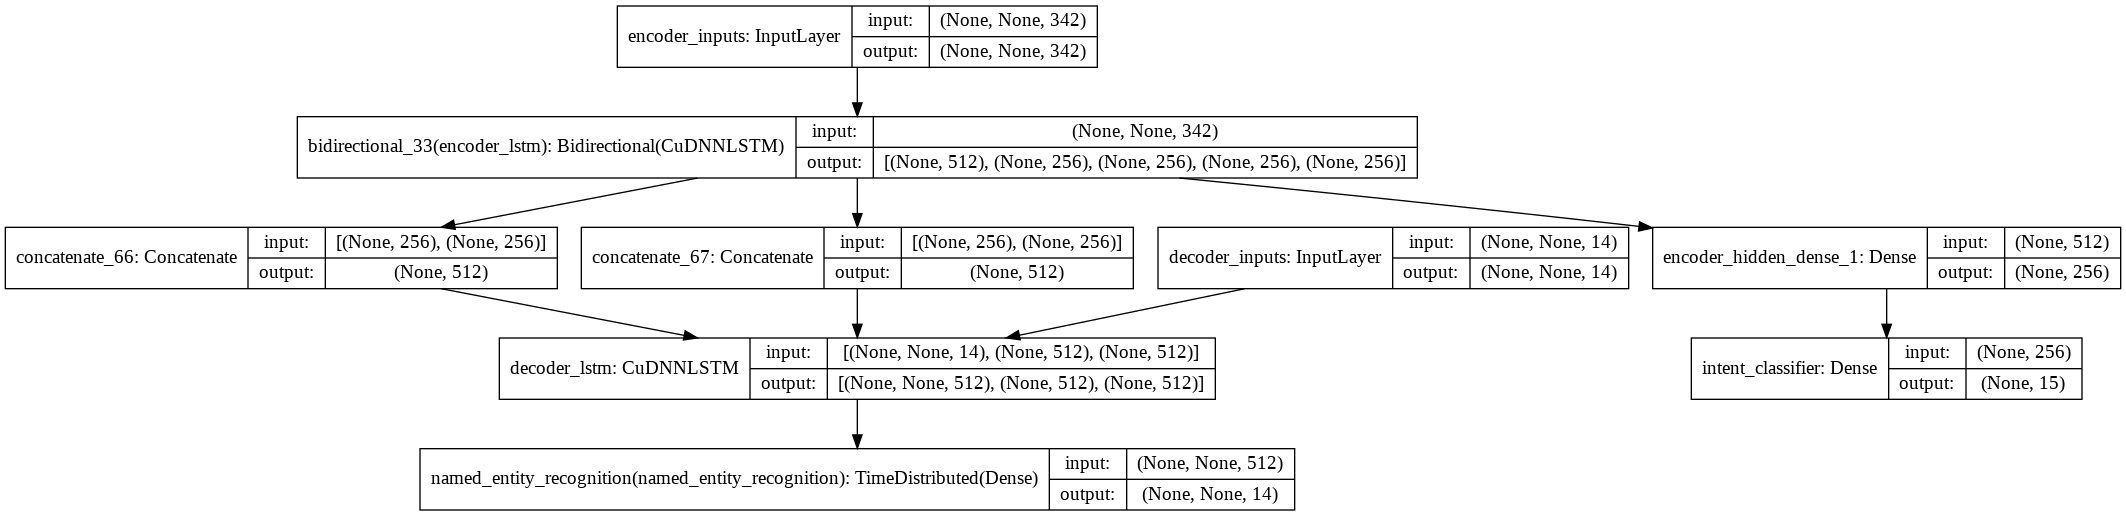

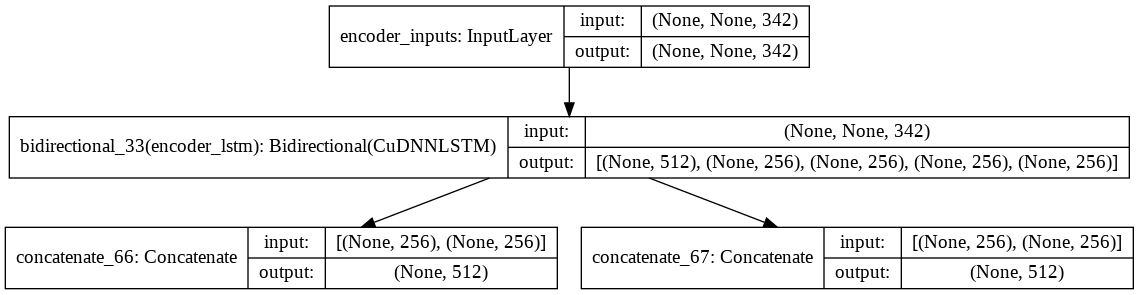

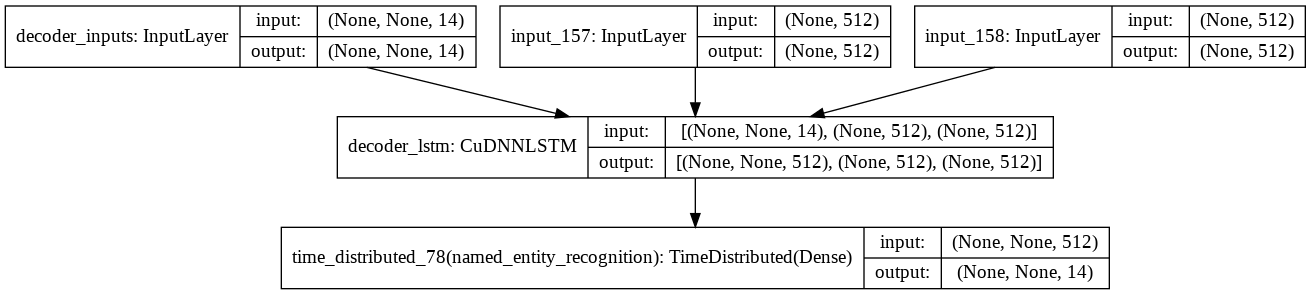

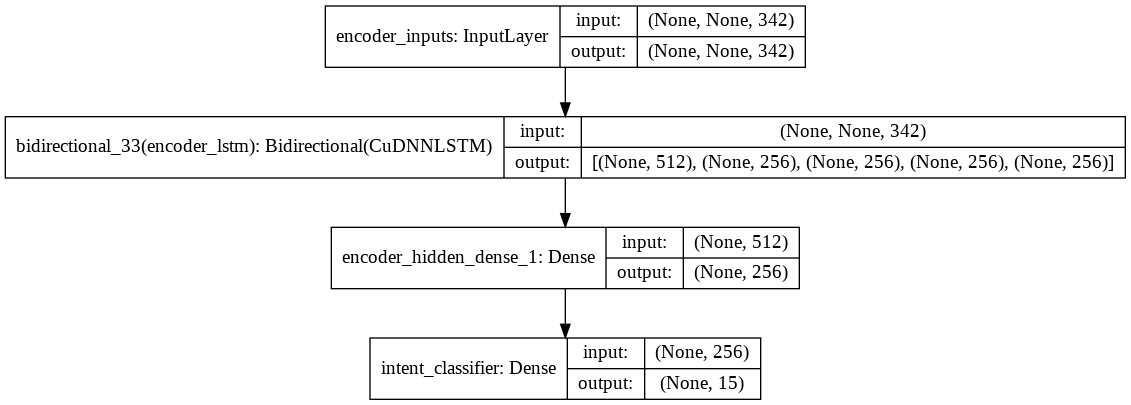



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 342)    0                                            
__________________________________________________________________________________________________
bidirectional_33 (Bidirectional [(None, 512), (None, 1228800     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 14)     0                                            
__________________________________________________________________________________________________
concatenate_66 (Concatenate)    (None, 512)          0           bidirectional_33[0][1]           
                                                                 bidirectional_33[0][3]           
________

In [53]:
%xdel model
model = EncoderDecoderBiLSTM(conf_obj)
model.save_model_image()
plot_model(model.inf_decoder_model, 
           to_file='./{}.png'.format('inf_decoder_model'),
           show_shapes=True,
           show_layer_names=True)
plot_model(model.inf_encoder_model, 
           to_file='./{}.png'.format('inf_encoder_model'),
           show_shapes=True,
           show_layer_names=True)
plot_model(model.inf_intent_classifier, 
           to_file='./{}.png'.format('inf_intent_classifier'),
           show_shapes=True,
           show_layer_names=True)

display(Image(model.model_name+'.png'))
print('\n')
display(Image('inf_encoder_model.png'))
print('\n')
display(Image('inf_decoder_model.png'))
print('\n')
display(Image('inf_intent_classifier.png'))
print('\n')

model.model.summary()

losses = {
    "intent_classifier": "categorical_crossentropy",
    "named_entity_recognition": "categorical_crossentropy",
}

metrics = {
    "intent_classifier": "categorical_accuracy",
    "named_entity_recognition": "categorical_accuracy",
}

lossWeights = {
    "intent_classifier": 1.0,
    "named_entity_recognition": 1.0
}

model.model.compile(optimizer=keras.optimizers.Adam(),
                    loss=losses, 
                    loss_weights=lossWeights,
                    metrics=metrics)


#Training loop

In [56]:
callbacks = [
#     keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Models_NLU/{}'.format(model.model_name),
#                                              monitor='val_loss', 
#                                              verbose=1, 
#                                              save_best_only=True, 
#                                              save_weights_only=True,
#            _dir                                  mode='auto', 
#                                              period=1)
    SaveModelOnBatch(model,
                     root='gdrive/My Drive/Models_NLU/')
]




size = sum(len(group) for group in GROUP.values())
steps = int(size/batch_size)+1
size_v = sum(len(group) for group in VALIDATION_GROUP.values())
steps_v = int(size_v/batch_size)+1

print(size_v/size)

train_H = model.model.fit_generator(generator=train_batch_real_gen(GROUP,w2v_model,steps,batch_size),
                                    validation_data = val_batch_real_gen(VALIDATION_GROUP,w2v_model,steps_v,batch_size),
                                    epochs=1,
                                    verbose=1,
                                    steps_per_epoch=steps,
                                    validation_steps = steps_v,
                                    workers = 1,
                                    callbacks=callbacks
                                   )

0.18035427834980874
4559/4559 [==============================] - 131s 29ms/step - loss: 0.0866 - intent_classifier_loss: 0.0276 - named_entity_recognition_loss: 0.0588 - intent_classifier_categorical_accuracy: 0.9922 - named_entity_recognition_categorical_accuracy: 0.9762 - val_loss: 0.0129 - val_intent_classifier_loss: 1.1228e-04 - val_named_entity_recognition_loss: 0.0103 - val_intent_classifier_categorical_accuracy: 1.0000 - val_named_entity_recognition_categorical_accuracy: 0.9939


In [67]:
TEST_GROUP = {group:[] for group in list(GROUP)}
for group in GROUP:
  print('CURRENT GROUP IS {}'.format(group))
  data = GROUP[group]
#   random.shuffle(data)
  test_index = int(len(data)*test_ratio+1)
  data_train = data[:-test_index]
  TEST_GROUP[group].extend(data[-test_index:])
  
  val_index = int(len(data_train)*val_ratio+1)
  data_val = data_train[-val_index:]
  #Should change this to skip validation data if not enough samples
#   if(len(data_val)) == 0:
#     data_vale=data_train
  train_steps_bound = 1 if len(data_train)%batch_size!=0 else 0
  val_steps_bound = 1 if len(data_val)%batch_size!=0 else 0
  
  steps_per_epoch = int(len(data_train)/batch_size + train_steps_bound)
  validation_steps = int(len(data_val)/batch_size + val_steps_bound)
  
  train_H = model.model.fit_generator(generator=train_batch_generator(data_train,w2v_model,steps_per_epoch,batch_size),
                                validation_data = val_batch_generator(data_val,w2v_model,validation_steps,batch_size),
                                epochs=1,
                                verbose=1,
                                steps_per_epoch=steps_per_epoch,
                                validation_steps = validation_steps,
                                workers = 1,
                                callbacks=callbacks
#                               class_weight=class_weights
#                               steps_per_epoch = 200
                             )


CURRENT GROUP IS 13


NameError: ignored

# Evaluating model

In [58]:
size_t = sum(len(group) for group in TESTING_GROUP.values())
steps_t = int(size_t/batch_size)+1

test_H = model.model.evaluate_generator(generator=test_batch_real_gen(TESTING_GROUP,w2v_model,steps_t,batch_size=batch_size),
                                         steps=steps_t,
                                         workers = 1,
                                         verbose=1)



1824/1824 [==============================] - 27s 15ms/step - loss: 0.0476 - intent_classifier_loss: 0.0287 - named_entity_recognition_loss: 0.0159 - intent_classifier_categorical_accuracy: 0.9911 - named_entity_recognition_categorical_accuracy: 0.9920


#Plotting training

# Save the models

In [0]:
# model.save_models_to_disk(root='gdrive/My Drive/Models_NLU/29May/')
model = EncoderDecoder(conf_obj)
model.load_models_to_disk(root='gdrive/My Drive/Models_NLU/29May/',new_name='base')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Testing with labels

In [77]:
for instance in TE_INSTANCES[5:15] : 
#   instance = d['train_dataset']['folders'][888]
  text = instance['text'].lower().split()
  # text = 'Show the home directory'.split()
  postags = nltk.pos_tag(text)
  postags = [t for (w,t) in postags]
  word_vectors = [ w2v(word,w2v_model) for word in text ]
  word_postags_encoded = [ POS2OH[w] for w in postags]
  x_train = np.array ([ np.concatenate((vec,postag),axis=None) for vec,postag in zip(word_vectors,word_postags_encoded)],dtype='float32')
  x_train = np.reshape(x_train,newshape=(1,x_train.shape[0],x_train.shape[1]))
  tags,intent= model.predict_sequence(x_train, len(x_train[0]))
  tags_decoded = [INDEX2TAG[np.argmax(pred)] for pred in tags]
  intent_decoded = [INDEX2INTENT[np.argmax(intent[0])]]
  print('text\t : {}'.format(text))
  print('true\t : {}'.format(instance['tags'].split()))
  print('pred\t : {}'.format(tags_decoded[:]))
  print('true\t : {}'.format(instance['intent'].split(' ')))  
  print('pred\t : {}'.format(intent_decoded))
  print()
#   print(intent)


text	 : ['could', 'you', 'search', 'for', 'the', 'file', 'public', 'please']
true	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'exch.file_name', 'NUL']
pred	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'exch.file_name', 'NUL']
true	 : ['request']
pred	 : ['request']

text	 : ['what', 'is', 'the', 'best', 'hdr', 'software']
true	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'NUL']
pred	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'NUL']
true	 : ['unknown']
pred	 : ['unknown']

text	 : ['could', 'you', 'please', 'create', 'the', 'chart', 'js', 'file']
true	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'alter.file_name', 'alter.file_name', 'NUL']
pred	 : ['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'alter.file_name', 'alter.file_name', 'NUL']
true	 : ['create_file_desire']
pred	 : ['create_file_desire']

text	 : ['can', 'you', 'duplicate', 'vampire', 'weeknd', 'file', 'from', 'spring', 'autoconfiguremetadataindex']
true	 : ['NUL', 'NUL', 'NUL', 'alter.file_name', 'alter.file_name', 'NUL', 'NUL', 'origin', 'origin']

# Testing without labels

In [60]:
texts = [
    'you will find amusing images in documents old',
    'where can i find the old pictures directory',
    'it is under the super java projects folder',
    'yes',
    'alright',
    'alright just do it',
    'could you move apl to apl',
    'yes please',
    'show me the home folder',
    'go to the home directory',
    'show the file named code.py',
    'delete home diretory',
    'could you go to the whole directory',
    'fine good',
    'sdddsds',
    'what the weather like today',
    'rename home3 to home2',
    'go for it',
    'hey open the bureau folder',
    'change name of olddsdsssds to newdddddd',
    'close the current folder',
    'erase the current folder',
    'Remove the current folder',
    'is it possible to remove the mushrooms folder',
    'I was wondering if you could go to the old memories folder please',
    'open home file',
    "yes please"
]
for text in texts:
  text = text.lower().split()
  word_vectors = [ w2v(word,w2v_model) for word in text ]
  postags = nltk.pos_tag(text)
  postags = [t for (w,t) in postags]  
  word_postags_encoded = [POS2OH[w] for w in postags]
  
  x_train = np.array ([ np.concatenate((vec,postag),axis=None) for vec,postag in zip(word_vectors,word_postags_encoded)],dtype='float32')
  x_train = np.reshape(x_train,newshape=(1,x_train.shape[0],x_train.shape[1]))
  tags,intent= model.predict_sequence(x_train, len(x_train[0]))
  tags_decoded = [INDEX2TAG[np.argmax(pred)] for pred in tags]
  intent_decoded = [INDEX2INTENT[np.argmax(intent[0])]]
  pr(text)
  pr(postags)
  print('{}'.format(tags_decoded[:]))
  print('{}'.format(intent_decoded))
  print('\n')

['you', 'will', 'find', 'amusing', 'images', 'in', 'documents', 'old']
['PRP', 'MD', 'VB', 'JJ', 'NNS', 'IN', 'NNS', 'JJ']
['NUL', 'NUL', 'NUL', 'exch.file_name', 'exch.file_name', 'NUL', 'exch.parent_directory', 'exch.parent_directory']
['inform']


['where', 'can', 'i', 'find', 'the', 'old', 'pictures', 'directory']
['WRB', 'MD', 'VB', 'VB', 'DT', 'JJ', 'NNS', 'NN']
['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'exch.directory_name', 'exch.directory_name', 'NUL']
['request']


['it', 'is', 'under', 'the', 'super', 'java', 'projects', 'folder']
['PRP', 'VBZ', 'IN', 'DT', 'JJ', 'NN', 'NNS', 'VBP']
['NUL', 'NUL', 'NUL', 'NUL', 'NUL', 'info.file_name', 'info.file_name', 'NUL']
['inform']


['yes']
['NNS']
['NUL']
['confirm']


['alright']
['NN']
['NUL']
['confirm']


['alright', 'just', 'do', 'it']
['NN', 'RB', 'VB', 'PRP']
['NUL', 'NUL', 'NUL', 'NUL']
['confirm']


['could', 'you', 'move', 'apl', 'to', 'apl']
['MD', 'PRP', 'VB', 'RB', 'TO', 'VB']
['NUL', 'NUL', 'NUL', 'alter.file_name', 'NUL', 'd

NameError: ignored

[0]

In [0]:
arch = [EncoderDecoderLSTM,EncoderDecoderBiLSTM]
denses = [32,64,128,256]
units= [128,256,512]
acts = ['relu']
opts = ['rmsprop']

n_intents = len(INTENT2OH)
n_tags = len(TAG2OH)

vector_size = 300#w2v_model.vector_size
postag_vec_size = len(POSTAG_SET)
batch_size = 300



# variate_postag(arch,
#                denses,
#                units,
#                acts,
#                opts,
#                GROUP,
#                VALIDATION_GROUP,
#                TESTING_GROUP,
#                model_name='Tests',
#                vector_size=vector_size,
#                n_intents=n_intents,
#                n_tags=n_tags,
#                postag_vec_size=postag_vec_size,
#                batch_size=batch_size
#                )


variate(arch,
               denses,
               units,
               acts,
               opts,
               GROUP,
               VALIDATION_GROUP,
               TESTING_GROUP,
               model_name='Tests',
               vector_size=vector_size,
               n_intents=n_intents,
               n_tags=n_tags,
               postag_vec_size=postag_vec_size,
               batch_size=batch_size
               )